In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math
from sklearn.naive_bayes import *
from sklearn.metrics import confusion_matrix

This notebook is an analysis of rat hippocampal recording data; the original dataset is posted <a href=https://crcns.org/data-sets/hc/hc-11/about-hc-11>here</a>.

## Unpacking the Data
This experiment contains **neural spiking** data and **rat position** data, saved into a `.mat` file. Because of the size of the data, Matlab saves it in a compressed format (hdf5) that must be read using the `h5py` module. We'll work with Cicero here, but if you'd like to explore more the Gatsby dataset is a different animal running on a linear track.

In [2]:
 f = h5py.File('Cicero_09102014_sessInfo.mat','r');
#f = h5py.File('Gatsby_08022013_sessInfo.mat','r');

This file contains a struct named `sessInfo` with fields `Position`, `Spikes`, and `Epochs`. `Position` and `spikes` contain the position of the rat as it runs along a track (called a maze), and the time of recorded spikes during this and other behaviors. `Epochs` gives the start and stop time of various behavioral assays (we'll ignore this for now and focus just on the maze-running experiment.)

### Position data
**`sessInfo.Positions`** gives the location of the rat while it runs on a (in this case circular) track. It has fields:
 * `MazeType`: the type of maze (ascii code, see conversion to string below)
 * `TwoDLocation`: the X- and Y- coordinates of the rat in the maze
 * `OneDLocation`: a 1D representation of the animal's position (ie how far around the circle it has run)
 * `TimeStamps`: the time at which the animal is at the given position (we'll use this to align to the spike data)

In [3]:
mazeType  = ''.join(chr(i) for i in np.squeeze(f['sessInfo']['Position']['MazeType'][()])); #converts ascii values to a string
time      = np.squeeze(f['sessInfo']['Position']['TimeStamps']);
pos2DRaw  = np.squeeze(f['sessInfo']['Position']['TwoDLocation']);
framerate = 1/np.mean(time[1:]-time[:-1]) #compute the framerate of position tracking as the mean difference between timestamps
T         = len(time);

The position data has some missing values (where the tracking failed). We can use `np.interp` to fill these in by linear interpolation. This works pretty well, although there are a few (rare) timepoints where the tracking does jump around.

In [4]:
pos2D    = np.copy(pos2DRaw);
x = lambda z: z.nonzero()[0]; # an anonymous helper function for interpolation
for i in range(0,2):
    nans = np.isnan(pos2D[i,:]);
    pos2D[i,nans] = np.interp(x(nans), x(~nans), pos2D[i,~nans]);

Here's what the position data looks like when we plot it:

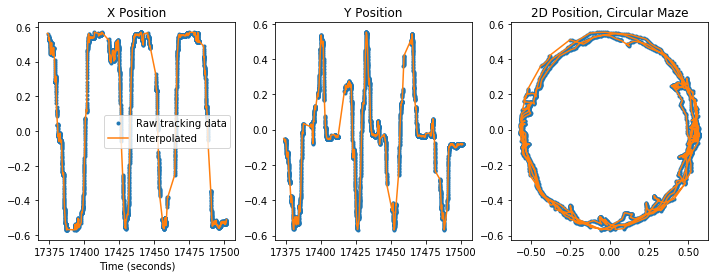

In [5]:
fig,ax = plt.subplots(1,3,figsize=(12,4));
inds = range(5000,10000);
ax[0].plot(time[inds],pos2DRaw[0,inds],'.',label='Raw tracking data');
ax[0].plot(time[inds],pos2D[0,inds],label='Interpolated');
ax[0].legend();
ax[0].set_title('X Position');
ax[0].set_xlabel('Time (seconds)')

ax[1].plot(time[inds],pos2DRaw[1,inds],'.',label='Raw tracking data');
ax[1].plot(time[inds],pos2D[1,inds],label='Interpolated');
ax[1].set_title('Y Position');
ax[0].set_xlabel('Time (seconds)')

ax[2].plot(pos2DRaw[0,inds],pos2DRaw[1,inds],'.',label='Raw tracking data');
ax[2].plot(pos2D[0,inds],pos2D[1,inds],label='Interpolated');
ax[2].set_title('2D Position, ' + mazeType);

Also to make life easier during decoding, we can try to decode the *phase* of the rat's trajectory around the maze, rather than its (x,y) position. This is given by:

In [6]:
linearPos = np.arctan2(pos2D[0,:-1],pos2D[1,:-1]); # for circular mazes

### Spiking data
`sessInfo.Spikes` contains the recorded neural spiking from the experiment, which includes both the maze-running session as well as several other behaviors we won't be considering here. It has the following fields:
 * `SpikeTimes`: the time (in seconds) at which each spike occurs
 * `SpikeIDs`: which recorded neuron fired each spike in `SpikeTimes`- eg, the tenth spike recorded happened at time `SpikeTimes[9]`, and was fired by neuron `SpikeIDs[9]`.
 * `PyrIDs`: the ID numbers of recorded neurons that are hypothesized (based on spike waveforms) to be pyramidal cells
 * `IntIDs`: the ID numbers of recorded numbers that are hypothesized to be inhibitory interneurons

In [7]:
spTimes = f['sessInfo']['Spikes']['SpikeTimes'][0];
spIDs   = f['sessInfo']['Spikes']['SpikeIDs'][0];
cells   = np.unique(spIDs);
N       = len(cells);

The original dataset contains spikes from a series of experiments; we only want to consider spikes that happened while the mouse was running on the maze, so we'll extract those out:

In [8]:
mazeTimes    = np.logical_and(spTimes>=min(time), spTimes<=max(time));
mazeSpikes   = spTimes[mazeTimes];
mazeIDs      = spIDs[mazeTimes];

Now, we're going to convert the data in `mazeSpikes` and `mazeIDs` into a *spike raster*. This is similar to the vector of spikes we constructed in module 1 (spike-triggered averaging), but now the spikes come from multiple neurons, so instead of a vector we create an $N$ (neurons) by $T$ (time) *matrix* of spikes.

In [9]:
raster = np.zeros((N+1,T-1));
for ind,i in enumerate(cells.T):
    raster[ind,:],_ = np.histogram(mazeSpikes[mazeIDs==i],time);

Here's what that spike raster looks like:

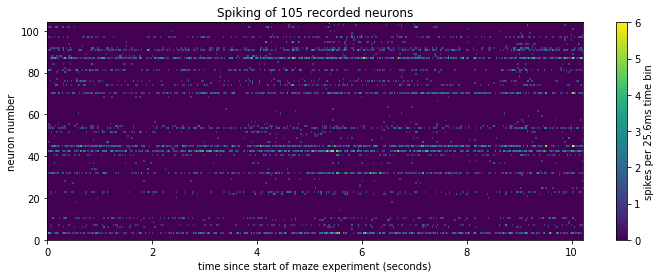

In [10]:
plt.figure(figsize=(12,4));
inds = range(0,400);
plt.imshow(raster[:,inds],extent=[time[inds[0]]-time[0],time[inds[-1]]-time[0],0,N-1],aspect='auto');
plt.title('Spiking of ' + str(N) + ' recorded neurons');
plt.xlabel('time since start of maze experiment (seconds)');
plt.ylabel('neuron number');
h=plt.colorbar();
h.set_label('spikes per ' + "{:.1f}".format(1/framerate*1000) + 'ms time bin');

That's the data unpacked! So **at time $t$, the rat is at position `pos2d[:,t]` (or linearlized position `linearPos[t]`), and the spiking activity of the N recorded neurons is given by `raster[:,t]`**.

Before going to the next step, we'll adjust `time` so the maze run starts at time 0 instead of 17,375, and then clear some variables that are no longer needed to free up memory.

In [11]:
time = time - time[0];
del f, spTimes, spIDs;

We're also going to define a helper function that we can use to smooth our spike raster with a moving average (you may find this useful for decoding.)

In [12]:
def smooth(a,WSZ):
    # a: NumPy 1-D or 2-D array containing the data to be smoothed (row-wise)
    # WSZ: smoothing window size needs, which must be odd number
    aSm = np.zeros(a.shape);
    if(len(a.shape)==1):
        out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ;
        r = np.arange(1,WSZ-1,2);
        start = np.cumsum(a[:WSZ-1])[::2]/r;
        stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1];
        aSm = np.concatenate((  start , out0, stop  ));
    else:
        for i in range(0,a.shape[0]):
            out0 = np.convolve(a[i,:],np.ones(WSZ,dtype=int),'valid')/WSZ;
            r = np.arange(1,WSZ-1,2);
            start = np.cumsum(a[i,:WSZ-1])[::2]/r;
            stop = (np.cumsum(a[i,:-WSZ:-1])[::2]/r)[::-1];
            aSm[i,:] = np.concatenate((  start , out0, stop  ));
    return aSm;

## Principal Component Analysis

This week, see if you can perform the following analyses:
- Use `sklearn.decomposition` to perform PCA (check the functions `pca.fit` and `pca.fit_transform` <a href=https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html>here</a>)
- Compute the principal components by taking the eigenvectors of the covariance matrix.
- Experiment with whitening and smoothing (look at effect on PCs and covariance matrix).
- Plot the PC loadings of neurons.
- Plot the projection of data onto the first few prinicpal axes.
- Look for position/behavioral correlates of PCs 

In [101]:
from sklearn.decomposition import *

velocity = np.sqrt((pos2D[0,2:]-pos2D[0,:-2])**2 + (pos2D[1,2:]-pos2D[1,:-2])**2)